<a href="https://colab.research.google.com/github/shrish23/Makemore/blob/master/Makemore(MLP_Batch_Normalization).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
#read all words
words = open('/content/names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of the characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3# context length: how many characters do we take to predict the next one?
def build_dataset(words):

  X,Y =[],[]# X:input, Y: labels
  for w in words:# First 5 words for efficiency

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '------->', itos[ix])
      context = context[1:] + [ix] #crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])    # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])    # 10%

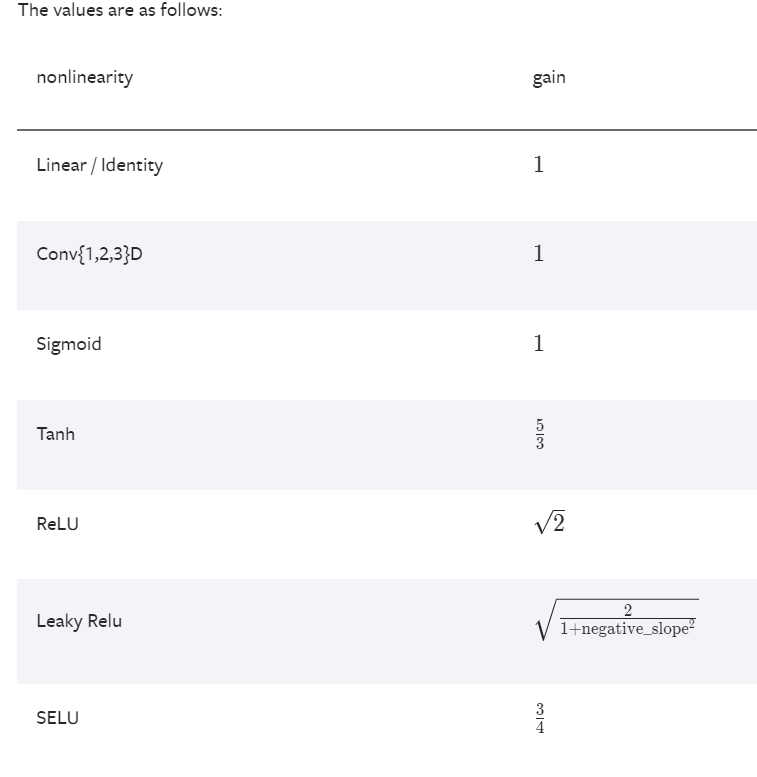

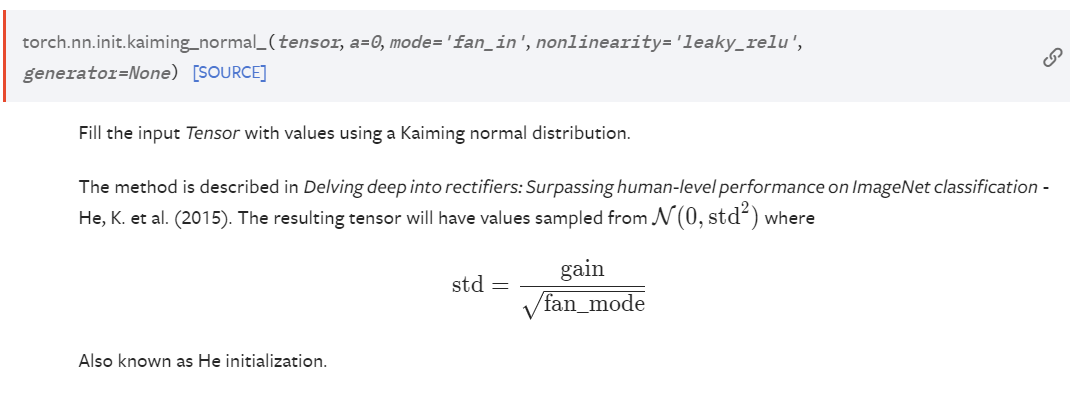

Now, we initialized the weights using the kaiming init method

In [ ]:
#MLP revisited
n_emd = 10# the dimensionality of the character embedding vectors
n_hidden = 200# the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)# for reproducibility
C = torch.randn((vocab_size, n_emd), generator=g)
W1 = torch.randn((n_emd*block_size, n_hidden), generator=g) *(5/3)/((n_emd*block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size,generator=g) * 0

#batch normalization parameters
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, W2,b2,bngain,bnbias]

print(sum(p.nelement() for p in parameters))#number of parameters in total
for p in parameters:
  print("Reach")
  p.requires_grad = True

12097
Reach
Reach
Reach
Reach
Reach
Reach


tensor(-0.0135) tensor(1.0122)
tensor(0.0043) tensor(1.0079)


(array([6.54476184e-05, 2.18158728e-05, 1.09079364e-04, 6.54476184e-05,
        1.30895237e-04, 2.83606347e-04, 5.01765075e-04, 6.98107930e-04,
        1.22168888e-03, 2.09432379e-03, 3.81777774e-03, 5.69394280e-03,
        1.00571174e-02, 1.40930538e-02, 2.34084315e-02, 3.66724822e-02,
        5.54995804e-02, 7.86025898e-02, 1.17129421e-01, 1.61328379e-01,
        2.18856836e-01, 2.80290334e-01, 3.41527489e-01, 3.93951031e-01,
        4.23533355e-01, 4.26849367e-01, 3.94256454e-01, 3.44690790e-01,
        2.85155274e-01, 2.17984201e-01, 1.66825979e-01, 1.18132951e-01,
        8.16349961e-02, 5.49323677e-02, 3.67161139e-02, 2.47610156e-02,
        1.67109586e-02, 9.66443166e-03, 6.21752375e-03, 3.88322536e-03,
        2.24703490e-03, 1.30895237e-03, 6.98107930e-04, 3.05422219e-04,
        1.52711110e-04, 2.83606347e-04, 4.36317456e-05, 4.36317456e-05,
        0.00000000e+00, 2.18158728e-05]),
 array([-5.73221970e+00, -5.50302877e+00, -5.27383785e+00, -5.04464693e+00,
        -4.8154560

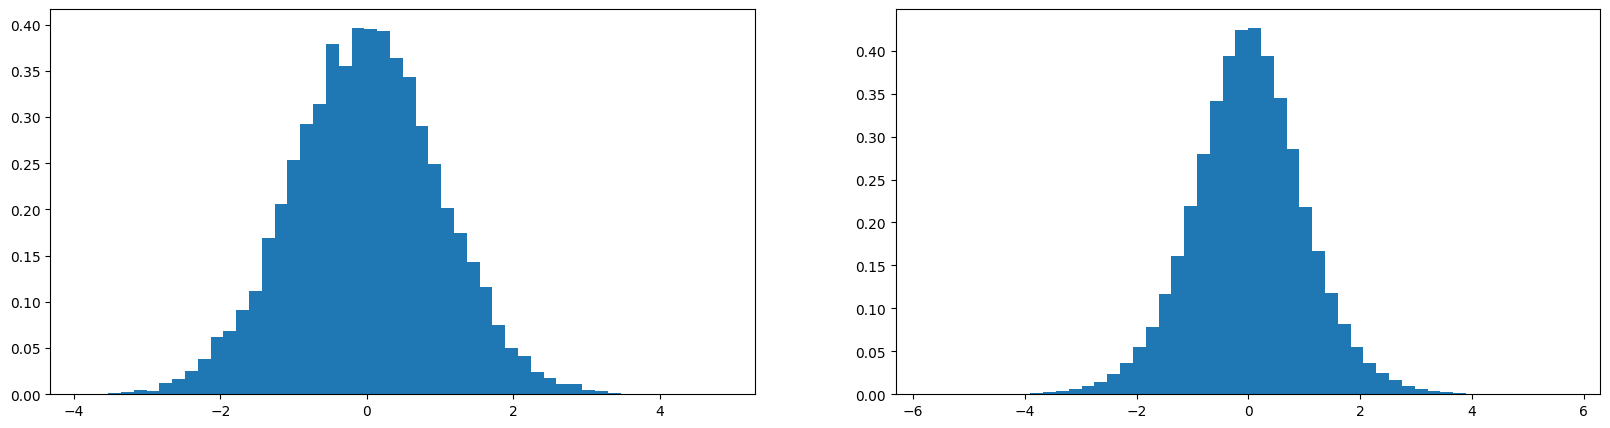

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(x.view(-1).tolist(), bins=50,density=True)
plt.subplot(1,2,2)
plt.hist(y.view(-1).tolist(), bins=50,density=True)

In [ ]:
# max_steps = 200000
# batch_size = 32
# lossi = []

# for i in range(max_steps):

#   # minibatch construct
#   ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
#   Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

#   #forward pass
#   emb = C[Xb] #embed the characters into vectors of size
#   embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
#   hpreact = embcat @ W1 + b1 #hidden layer pre-activation
#   h = torch.tanh(hpreact)#hidden layer
#   logits = h @ W2 + b2 #output layer
#   loss = F.cross_entropy(logits, Yb) # loss function

#   #backward pass
#   for p in parameters:
#     p.grad = None
#   loss.backward()

#   #update
#   lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
#   for p in parameters:
#     p.data += -lr * p.grad

#   #track stats
#   if i % 10000 == 0:
#     print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
#   lossi.append(loss.log10().item())



Now since we are scaling down the weights and the biases to make their mean roughly gaussian so that the hidden layer pre activation is not too large to begin with as it contributes to loss in the beginning.

So, we use batch normalization instead which says to make the hidden layer gaussian which has mean roughly 0

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #forward pass
  emb = C[Xb] #embed the characters into vectors of size
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear Layer
  hpreact = embcat @ W1 #+ b1 #hidden layer pre-activation
  # We can comment the bias above as the batch normalization layer has its own
  # bias and this bias does not have any value as eventually it is subtracted
  #(hpreact - bnmeani)
  # Batch normalization Layer
  #----------------------------------------------------
  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)
  hpreact = bngain * (hpreact - bnmeani)/ bnstdi + bnbias #normalize the hidden layer pre activation

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  #--------------------------------------------------------
  #Non-Linearity
  h = torch.tanh(hpreact)#hidden layer
  logits = h @ W2 + b2 #output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


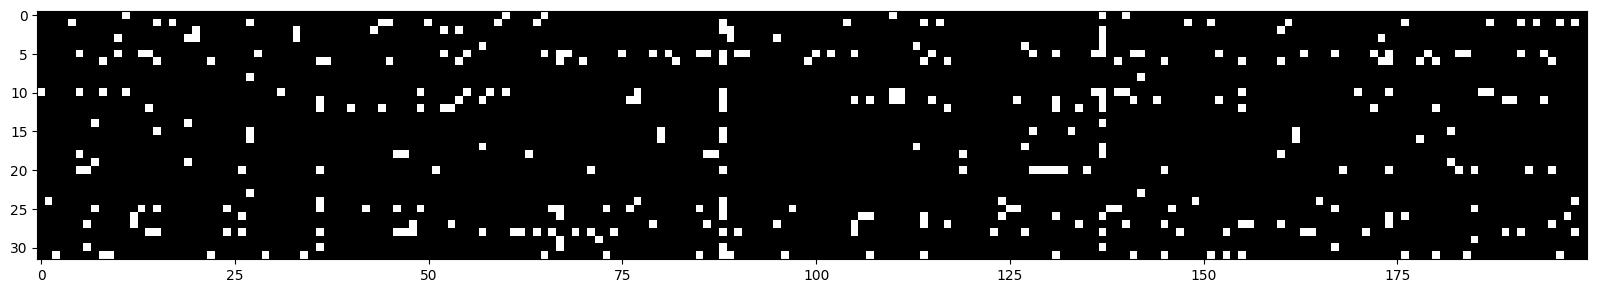

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([463., 241., 185., 165., 147., 111.,  97., 124.,  93., 102., 107.,
         76., 107.,  95., 108., 113.,  89.,  96., 112.,  93., 118.,  85.,
         67., 132., 111., 112., 106., 107.,  85.,  92., 103.,  80.,  93.,
         91.,  81.,  93., 120.,  82., 118., 110., 103., 103., 110., 114.,
        114., 135., 166., 171., 242., 432.]),
 array([-9.99993980e-01, -9.59995644e-01, -9.19997308e-01, -8.79998972e-01,
        -8.40000637e-01, -8.00002301e-01, -7.60003965e-01, -7.20005629e-01,
        -6.80007293e-01, -6.40008957e-01, -6.00010622e-01, -5.60012286e-01,
        -5.20013950e-01, -4.80015614e-01, -4.40017278e-01, -4.00018942e-01,
        -3.60020607e-01, -3.20022271e-01, -2.80023935e-01, -2.40025599e-01,
        -2.00027263e-01, -1.60028927e-01, -1.20030591e-01, -8.00322556e-02,
        -4.00339198e-02, -3.55839729e-05,  3.99627519e-02,  7.99610877e-02,
         1.19959424e-01,  1.59957759e-01,  1.99956095e-01,  2.39954431e-01,
         2.79952767e-01,  3.19951103e-01,  3.59949

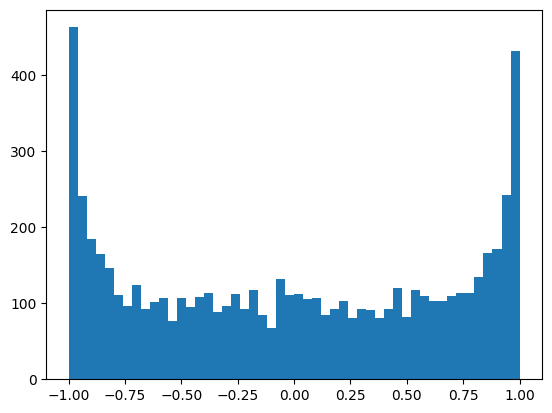

In [ ]:
plt.hist(h.view(-1).tolist(), bins=50)

(array([  1.,   0.,   0.,   0.,   2.,   1.,   1.,   2.,   4.,  11.,  14.,
         18.,  13.,  19.,  42.,  54.,  66.,  84., 103., 123., 170., 216.,
        262., 273., 347., 423., 524., 599., 537., 456., 416., 323., 247.,
        240., 185., 148., 129.,  81.,  82.,  57.,  39.,  29.,  19.,  16.,
         11.,   5.,   3.,   2.,   1.,   2.]),
 array([-6.35470009, -6.12598596, -5.89727182, -5.66855769, -5.43984356,
        -5.21112943, -4.98241529, -4.75370116, -4.52498703, -4.2962729 ,
        -4.06755877, -3.83884463, -3.6101305 , -3.38141637, -3.15270224,
        -2.9239881 , -2.69527397, -2.46655984, -2.23784571, -2.00913157,
        -1.78041744, -1.55170331, -1.32298918, -1.09427505, -0.86556091,
        -0.63684678, -0.40813265, -0.17941852,  0.04929562,  0.27800975,
         0.50672388,  0.73543801,  0.96415215,  1.19286628,  1.42158041,
         1.65029454,  1.87900867,  2.10772281,  2.33643694,  2.56515107,
         2.7938652 ,  3.02257934,  3.25129347,  3.4800076 ,  3.70872173,
 

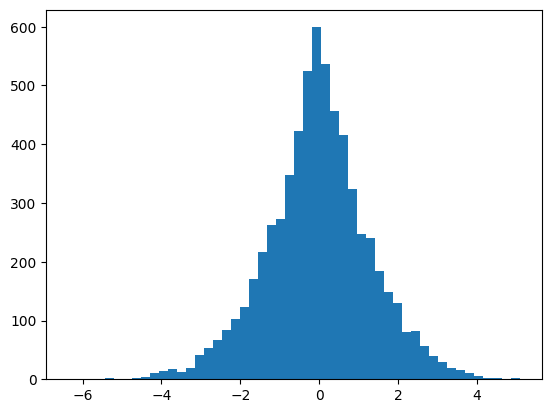

In [ ]:
plt.hist(hpreact.view(-1).tolist(), bins=50)

We can see that the pre-activation values are way too large. Which are actually responsible for the gradient values to pass through by falling on the flatlines of the tanh function

In [ ]:
logits[0]

tensor([-2.9432,  1.7033, -0.1491, -0.6337, -0.2506,  1.9912, -1.0582, -1.1586,
        -0.0168,  2.3002, -2.0891, -1.5072,  2.9150,  1.6254,  2.9859,  0.7832,
        -0.6382, -3.9366,  1.3895,  1.1865,  0.8465, -1.4758,  0.3449, -2.4001,
        -2.2058,  2.5448, -0.3120], grad_fn=<SelectBackward0>)

As we see above the intial loss at 1st iteration is 27 which is wrong and too much.

But in the start we want each character to have the same probability of coming next i.e. 1/27

In [ ]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

This is the loss we would expect which is much lower

In [ ]:
#4-dimensional example of the issue
logits = torch.tensor([0.0,0.0,0.0,0.0])
# logits = torch.randn(4)*10 # so basically these random initialized logits at initialization cause loss to increase
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
logits, probs,loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

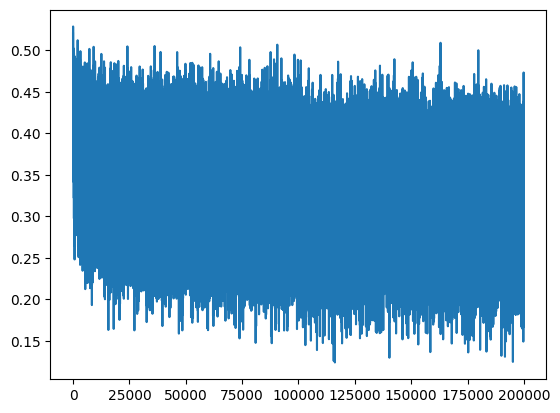

In [ ]:
plt.plot(lossi)

Fixing the mean and standard deviation so that the mean and std do not change for each example

In [ ]:
# # calibrate the batch norm at the end of training

# with torch.no_grad():
#   # pass the training set through
#   emb = C[Xtr]
#   embcat = emb.view(emb.shape[0], -1)
#   hpreact = embcat @ W1 + b1
#   #measure the mean and std over the entire training set
#   bnmean = hpreact.mean(0,keepdim=True)
#   bnstd = hpreact.std(0,keepdim=True)

Now the above code calculates the mean and std of the batch normalization after the training.

But we do not want to calculate it separately so we calculate the running mean and std along with the training

In [ ]:
@torch.no_grad()# this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x]# (N, block_size, n_emb)
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors into (N, block_size * n_emb)
  hpreact = embcat @ W1 + b1 #hidden layer pre-activation
  hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias #normalize the hidden layer pre activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066636800765991
val 2.105013132095337


In [ ]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    #forward pass the neural net
    emb = C[torch.tensor([context])]# (1,block_size,n_emb)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    #sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))#decode and print the generated word

briangmyazziyes.
bdulyah.
briyas.
brdrner.
sherkodrlithlyllsenleigh.
santhannchyziohmkrrnn.
shdumrishimnest.
jadestly.
prgbdulfuubdgghder.
jaquezmashburjahsis.
dashby.
sadya.
sus.
zakquslutel.
subristia.
sumprrdnn.
quloeonandphillsamreyxa.
hunton.
bdasirfalvinnwrllwildtalfr.
tandysestss.


# SUMMARY

Pytorchifying the above codes

In [ ]:
# Let's train a deeper Neural Network

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in,fan_out),generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)# bngain
    self.beta = torch.zeros(dim) # bnbias
    #buffers (trained with running 'momentum update)
    self.running_mean = torch.zeros(dim)#bnmean_running
    self.running_var = torch.ones(dim)#bnmstd_running

  def __call__(self,x):
    #calculating the forward pass
    if self.training:
      xmean = x.mean(0,keepdims=True)  #batch mean
      xvar = x.var(0,keepdims=True) #batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    #update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum*xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum*xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) #reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden), Tanh(),
    Linear(         n_hidden,   vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3
# the 5/3 is the gain factor as the Tanh is a squashing function the layer tends to get squashed to 0
# so some gain is required to prevent that.

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) #reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,   vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0#5/3 # Since batch normalization does not require the gain to be applied
# the 5/3 is the gain factor as the Tanh is a squashing function the layer tends to get squashed to 0
# so some gain is required to prevent that.

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47551


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud=[]

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #forward pass
  emb = C[Xb] #embed the characters into vectors of size
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  #backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break #AFTER_DEBUG would take out to run the full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

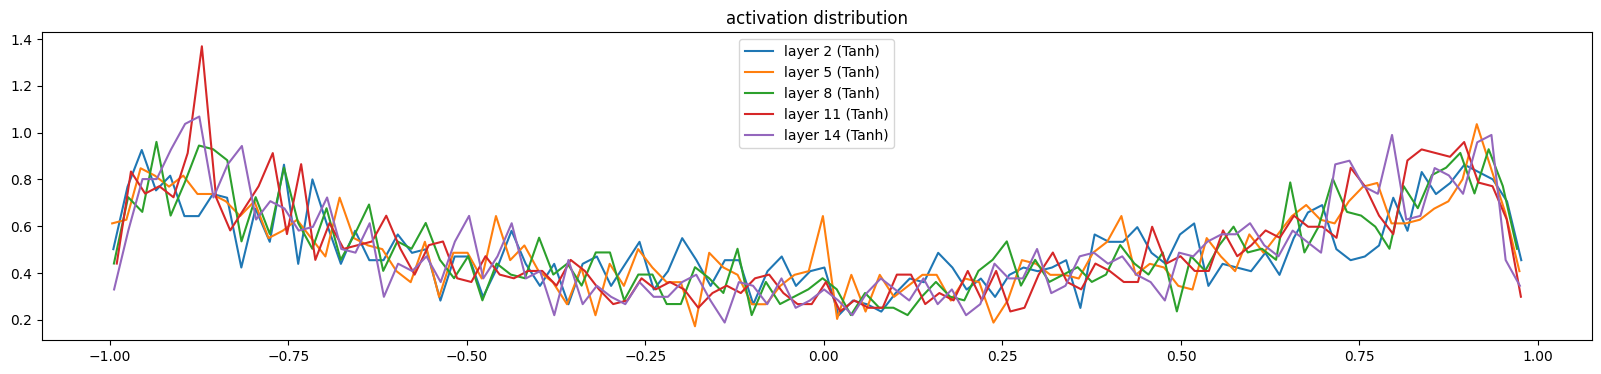

In [ ]:
#Visualize histogram
plt.figure(figsize=(20,4))  #width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):# note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.640701e-03
layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045741e-03
layer 11 (      Tanh): mean -0.000000, std 1.983132e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

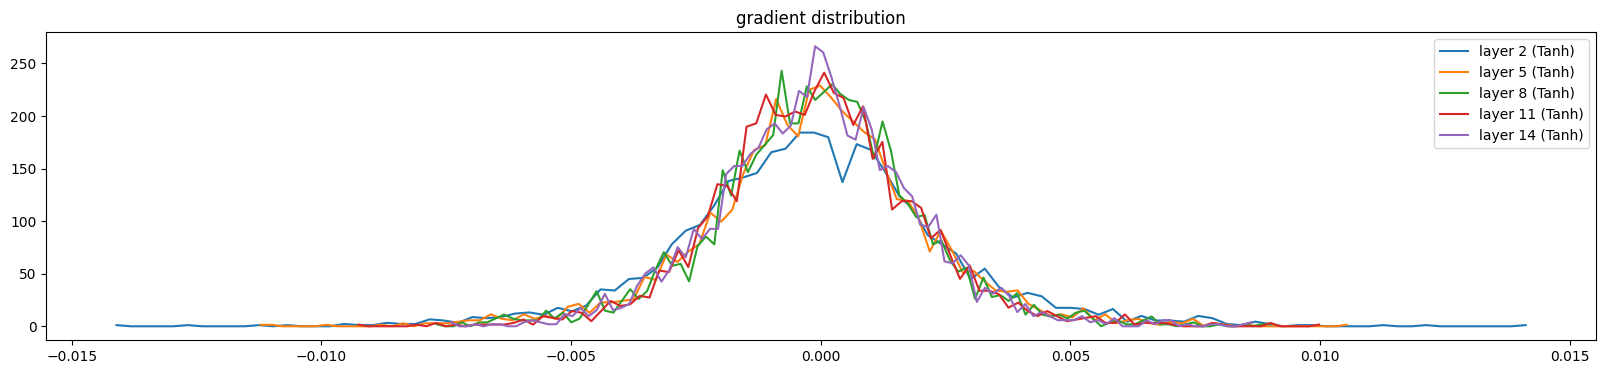

In [ ]:
#Visualize histogram
plt.figure(figsize=(20,4))  #width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):# note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.020527e-03 | grad:data ratio 8.012623e-03
weight  (30, 100) | mean +0.000246 | std 9.241064e-03 | grad:data ratio 4.881084e-02
weight (100, 100) | mean +0.000113 | std 7.132873e-03 | grad:data ratio 6.964613e-02
weight (100, 100) | mean -0.000086 | std 6.234302e-03 | grad:data ratio 6.073738e-02
weight (100, 100) | mean +0.000052 | std 5.742181e-03 | grad:data ratio 5.631477e-02
weight (100, 100) | mean +0.000032 | std 5.672201e-03 | grad:data ratio 5.570121e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


Text(0.5, 1.0, 'weights gradient distribution')

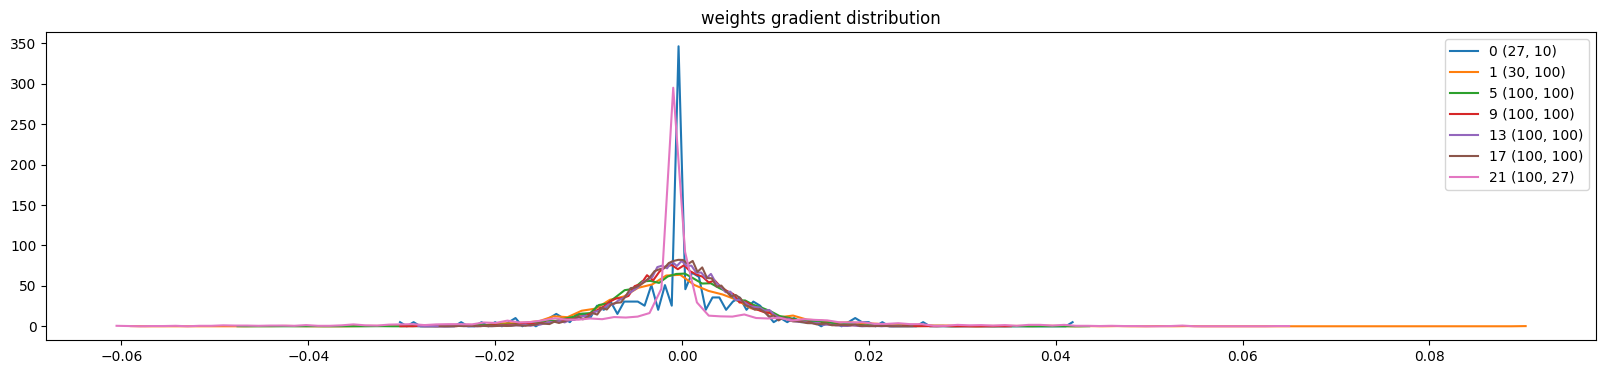

In [ ]:
#Visualize histogram
plt.figure(figsize=(20,4))  #width and height of the plot
legends = []
for i, p in enumerate(parameters):# note: exclude the output layer
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

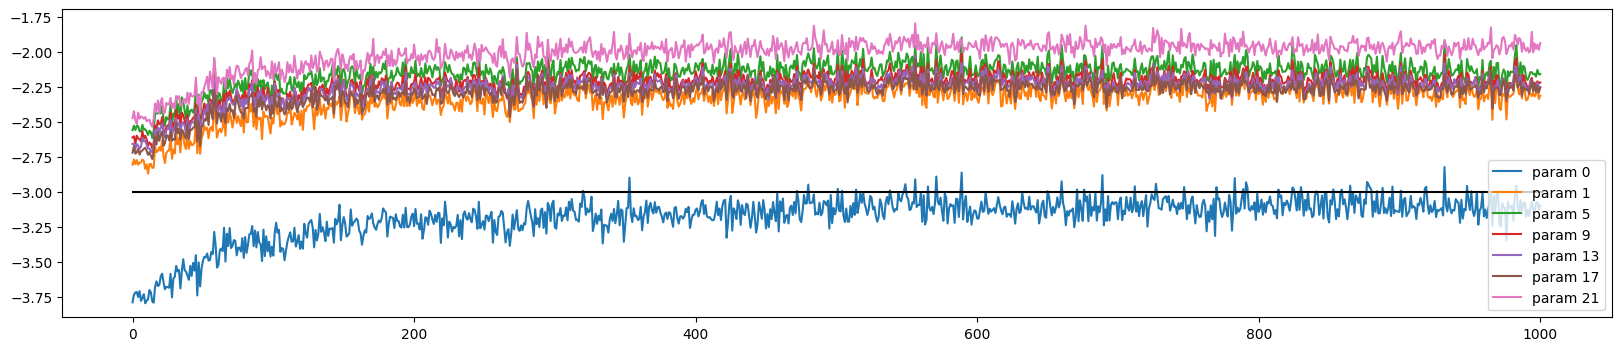

In [ ]:
#Visualize histogram
plt.figure(figsize=(20,4))  #width and height of the plot
legends = []
for i, p in enumerate(parameters):# note: exclude the output layer
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k')# these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

We can see that the layers are learning faster and are above the learning rate line.

This indicates that the lr can be a bit more as the layers are above the line.

We also see that the last layer is an outlier in the graph because the last layer was shrunk down and made unconfident, by making the weights multiply by 0.1. So the ration is more